In [1]:
import numpy as np
import seaborn as sns
import qutip as qt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
#     Two level system.
#                                      
#       -------|b>       
#          |             
#          |            
#          |            
#       -------|a>     
#                         

def GetNLevelBasis(numLevels):
    # use this to set basis in one line.
    lstKets = []
    for i in range(numLevels):
        lstKets.append(qt.basis(numLevels,i))
    return lstKets

def GetNLevelOperators(allKets):
    # use this to get transition operators in one line.
    lstOperators = []
    for ket in allKets:
        for i in range(len(allKets)):
            lstOperators.append(qt.tensor(ket*allKets[i].dag()))
    return lstOperators

def GetCollapseOperators(decayRates,transitionOperators):
    # use this to get dissipation operators in one line.
    lstCollapseOperators = []
    for i in range(len(decayRates)):
        lstCollapseOperators.append(np.sqrt(decayRates[i])*transitionOperators[i])
    return lstCollapseOperators
def NormalizeToMax(data,normFactor=1.0):
    """Normalizes a list to its maximum value.

    Args:
        data: A list of numerical values. normFactor: the value you want to normalize the values to.

    Returns:
        A new list with values normalized to the maximum value.
    """
    if not data:
        return []

    max_value = max(data)

    return [x *normFactor / max_value for x in data]

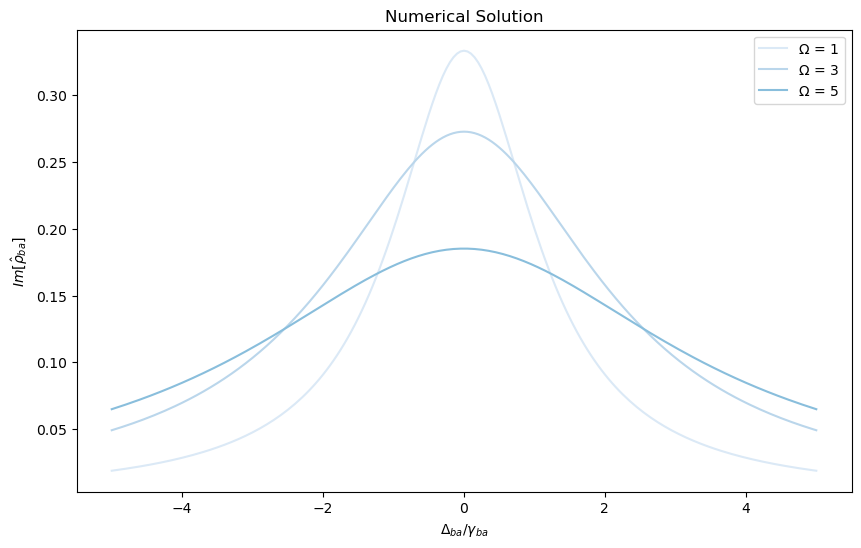

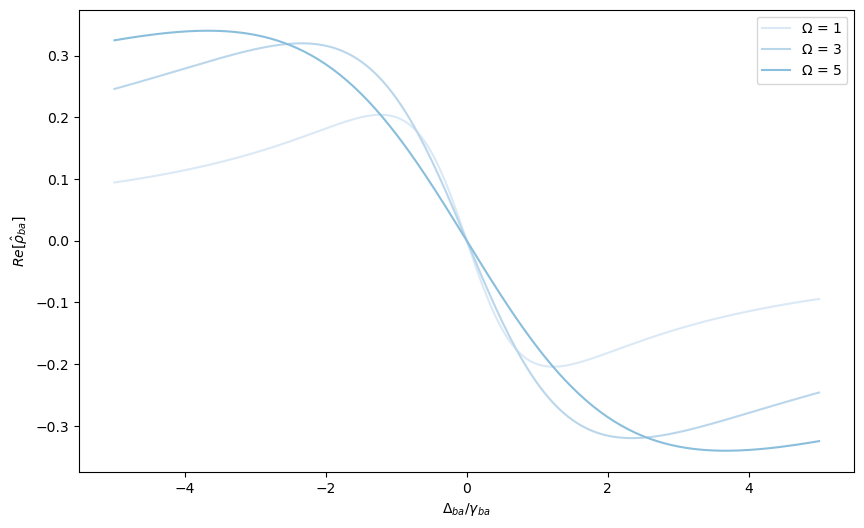

In [3]:
class AtomicSystem():
    def __init__(self):
        self.absorptionValues = []
        self.dispersionValues = []
        self.Susceptibility = pd.DataFrame()
        
        self.detuningCouple = 0
        self.detuningProbe = 0
        self.detuningMicrowave = 0
        self.detuningRange = 0
        self.numStepsDetuning = 0
        
        self.omegaCouple = 0

        self.decayRateCouple = 0

        self.decayRates = []
        self.collapseOperators = []
        self.basisSet = []
        self.H = qt.Qobj()

        self.rabiFrequencies = []

        self.numTrajectories = 0
        self.timeSpan = []
        self.initialState = []
        self.singleTrajectory = []
        self.Simulations = pd.DataFrame()
        self.fig = []

    def GetSusceptibility(self):
        # it's faster to create and append lists and then convert to dataframe at end, rather than appending dataframe.
        self.absorptionValues = []
        self.dispersionValues = []
        
        # Set variables necessary for calculations.
        self.decayRates = [self.decayRateCouple*2]
        one,two = GetNLevelBasis(2)    # Lambda system. level 3 is excited state.
        self.basisSet = [one,two]
        # Get all the transition operators, but note that we won't use all of them.
        sig11,sig12,sig21,sig22 = GetNLevelOperators(self.basisSet)

        # Get the collapse operators. This is an open system with dissipation.
        c1 = GetCollapseOperators(self.decayRates,[sig12])
        self.collapseOperators = [c1]
        detuningValues = np.linspace(-self.detuningRange,self.detuningRange,self.numStepsDetuning+1)

        # Scan the probe beam and get the susceptibility values.
        scaledDetuningValues = [detuning/self.decayRateCouple for detuning in detuningValues]
        for detuningValue in scaledDetuningValues:
            self.detuningCouple = detuningValue
            #   Define Hamiltonian.
            self.H = qt.Qobj([[0,self.omegaCouple/2],
                        [self.omegaCouple/2,self.detuningCouple]])
            rhoSteadyState = qt.steadystate(self.H,c1)

            self.absorptionValues.append(np.imag(rhoSteadyState[0,1]))
            self.dispersionValues.append(np.real(rhoSteadyState[0,1]))

        #self.absorptionValues = NormalizeToMax(self.absorptionValues)
        #self.dispersionValues = NormalizeToMax(self.dispersionValues,0.5) # dispersion values go from -0.5 to 0.5 when normalized.
        self.dfSusceptibility = (pd.DataFrame(list(zip(detuningValues,self.absorptionValues,self.dispersionValues))
                ,columns=['relativeDetuning','absorptionValues','dispersionValues']))
        
        return self.dfSusceptibility
    def PlotAbsorption_VaryCoupleBeam(self):
        # some plotting preferences.
        sns.set_palette("Blues") # this helps distinguish the different plots.
        plt.figure(figsize=(10, 6))
        for rabiFrequency in self.rabiFrequencies:
            self.omegaCouple = rabiFrequency
            self.dfSusceptibility = self.GetSusceptibility()
            sns.lineplot(data=self.dfSusceptibility,x="relativeDetuning",y="absorptionValues",
                         label =r"$\Omega$" + " = " + str(rabiFrequency))
        plt.title("Numerical Solution")
        plt.ylabel(r"$Im[\hat{\rho}_{ba}]$")
        plt.xlabel(r"$\Delta_{ba}/\gamma_{ba}$")
        plt.show()
    def PlotDispersion_VaryCoupleBeam(self):
        # some plotting preferences.
        sns.set_palette("Blues") # this helps distinguish the different plots.
        plt.figure(figsize=(10, 6))
        for rabiFrequency in self.rabiFrequencies:
            self.omegaCouple = rabiFrequency
            self.dfSusceptibility = self.GetSusceptibility()
            sns.lineplot(data=self.dfSusceptibility,x="relativeDetuning",y="dispersionValues",
                         label =r"$\Omega$" + " = " + str(rabiFrequency))
        plt.ylabel(r"$Re[\hat{\rho}_{ba}]$")
        plt.xlabel(r"$\Delta_{ba}/\gamma_{ba}$")
        plt.show()

twoLevel = AtomicSystem()

twoLevel.numStepsDetuning = 200 # the more steps, the better the resolution. we are scanning the detuning of the probe beam.

'''
These are properties of the system. Varying these values gives insights to EIT behavior.
'''
#   Decay rates.
twoLevel.decayRateCouple = 1.0
twoLevel.rabiFrequencies = [1,3,5] 
twoLevel.detuningRange = 5 # magnitude of the detuning that will be scanned for the probe beam.   
'''
Plot numerical solution.
'''
twoLevel.PlotAbsorption_VaryCoupleBeam()
twoLevel.PlotDispersion_VaryCoupleBeam()

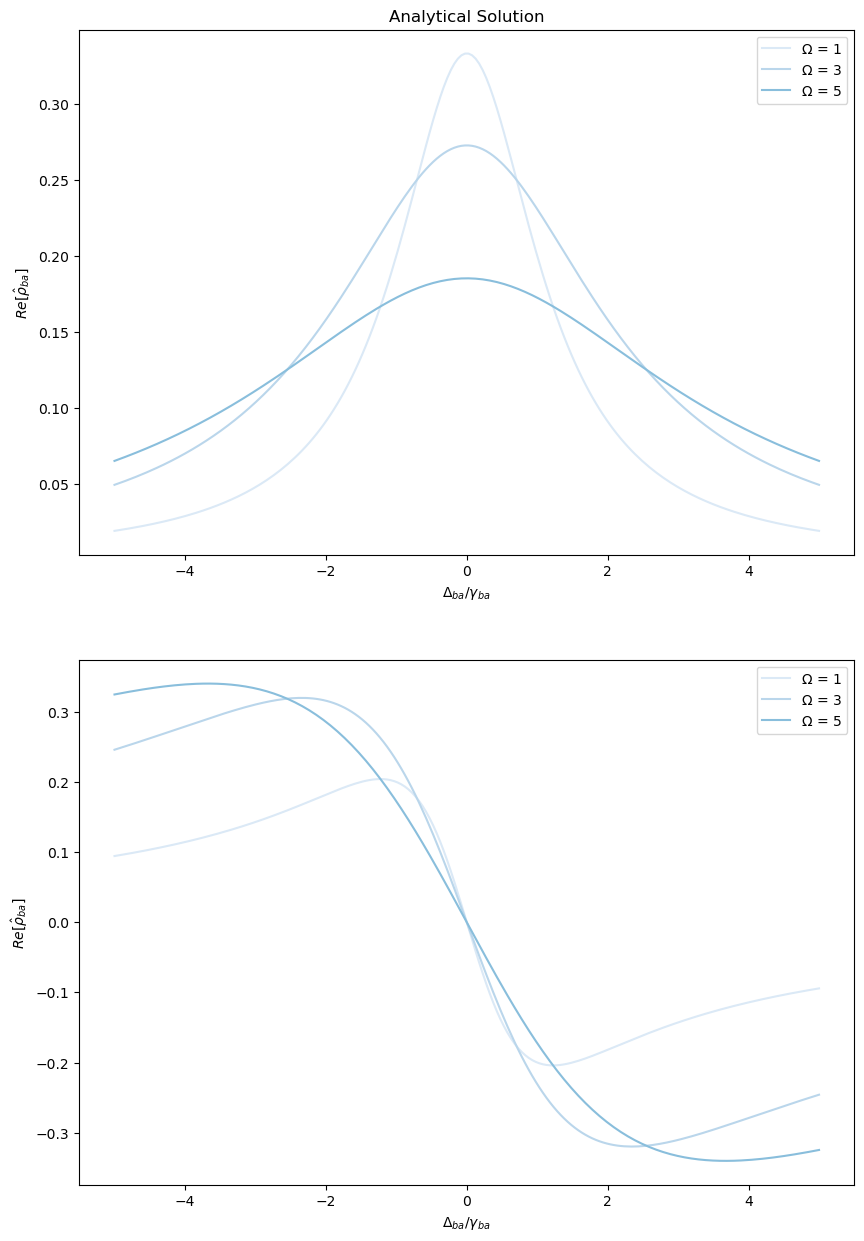

In [4]:
'''
Plot analytical solution.
'''
detuningSteps = 200
decayRate = 1
detuningValues = np.linspace(-5,5,detuningSteps)
rabiFrequencies = [1,3,5]
groundStatePopulation = 1
excitedStatePopulation = 0

scaledDetuningValues = [detuning/decayRate for detuning in detuningValues]
absorptionValues = []
dispersionValues = []
rhoSteadyState = []
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 15))

for rabiFrequency in rabiFrequencies:
    for detuningValue in scaledDetuningValues:
        alpha = 0.5*1j*rabiFrequency/(-decayRate + 1j*detuningValue)
        beta = 0.5*1j*rabiFrequency
        rho_aa = 0.5*beta*(alpha-np.conj(alpha))/(decayRate+alpha*beta-np.conj(alpha)*beta)
        rho_ba = alpha*(2*rho_aa-1)
        rhoSteadyState.append(rho_ba)
    axes[0].plot(scaledDetuningValues,np.imag(rhoSteadyState),label =r"$\Omega$" + " = " + str(rabiFrequency))
    axes[1].plot(scaledDetuningValues,np.real(rhoSteadyState),label =r"$\Omega$" + " = " + str(rabiFrequency))
    rhoSteadyState = []
axes[0].set_title("Analytical Solution")
for i in range(2):
    axes[i].set_ylabel(r"$Re[\hat{\rho}_{ba}]$")
    axes[i].set_xlabel(r"$\Delta_{ba}/\gamma_{ba}$")
    axes[i].legend(loc='upper right')
plt.show()